## Loading libraries and data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sub_sample = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

## Exploratory analysis

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print(f"train data's shape: {df_train.shape}")
print(f"test data's shape: {df_test.shape}")

train data's shape: (7613, 5)
test data's shape: (3263, 4)


In [5]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
df_train.groupby(df_train.target).count().text

target
0    4342
1    3271
Name: text, dtype: int64

* 0 corresponds to a fake tweet
* 1 correponds to a tweet about a real disaster

We will only keep text data

In [7]:
train = df_train.iloc[:,3:]
test = df_test.iloc[:,3:] 

train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## Data preparation

We will:
* remove tags
* remove hyperlinks
* remove emojis
* remove symbols
* remove capital letters
* remove ponctuation
* lemitize the text

In [8]:
import re
import emoji
import string
from nltk.stem import WordNetLemmatizer

def text_processing(txt):
    # remove @person tags
    txt = re.sub(r'@[A-Za-z0-9_]+','',txt)
    # remove Tweeter's symbols
    txt = re.sub(r'#','',txt)
    txt = re.sub(r'RT : ','',txt)
    # remove new lines
    txt = re.sub(r'\n',' ',txt)
    # remove emojis
    txt = re.sub(emoji.get_emoji_regexp(), r"", txt)
    # remove links
    txt = re.sub(r"https?:\/\/[A-Za-z0-9\.\/]+","",txt)
    txt = re.sub(r"https?://\S+|www\.\S+","",txt)
    # remove symbols
    txt = re.sub(r"<.*?>"," ",txt)
    # remove puncuation
    txt = txt.translate(str.maketrans('','',string.punctuation))
    # capitalization
    txt = txt.lower()
    # lemmitzation
    lemmatizer = WordNetLemmatizer()
    txt = lemmatizer.lemmatize(txt)

    return txt.strip()

In [9]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def remove_stopwords(txt):
    txt = [word.lower() for word in txt.split() if word.lower() not in stop]
    return " ".join(txt)

In [10]:
for _ in range(3):
    n = np.random.randint(7613)
    print("\nText before processing:")
    print(train['text'][n])
    print("\nAfter:")
    print(remove_stopwords(text_processing(train['text'][n])))
    print("----------------------------------")


Text before processing:
Here we fucking go with the injuries again who's next? https://t.co/TuzacdWFqd

After:
fucking go injuries whos next
----------------------------------

Text before processing:
this is about to be a bomb ass firework picture http://t.co/lr4BTvuEoM

After:
bomb ass firework picture
----------------------------------

Text before processing:
Policyholders object to Clico rescue plan http://t.co/E4DvI9vUXZ http://t.co/JyCpf8iYhg

After:
policyholders object clico rescue plan
----------------------------------


In [11]:
train.text = train.text.apply(text_processing)
train.text = train.text.apply(remove_stopwords)

test.text = test.text.apply(text_processing)
test.text = test.text.apply(remove_stopwords)

### TF-iDF embedding

In [12]:
corpus=train['text'].values

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000)
vectorizer.fit(corpus)
mat=vectorizer.transform(corpus).toarray()
features = vectorizer.get_feature_names()
mat.shape

(7613, 10000)

In [14]:
# top n features
n=20
indices = np.argsort(vectorizer.idf_)[::-1]
top_features = [features[i] for i in indices[:n]]
print(top_features)

['ûónegligence', 'runaway', 's3xleak', 's5', 's61231a', 'sa15t', 'saadthe', 'saat', 'sabotagei', 'sabrina', 'sackings', 'sackville', 'sacrifice', 'saddle', 'saddledome', 'sadtraumatised', 'safari', 's01e09', 'ryt', 'ryans']


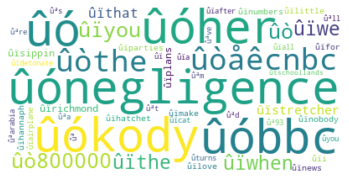

In [15]:
from wordcloud import WordCloud
x = vectorizer.vocabulary_
Cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(x)
plt.imshow(Cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(mat,train['target'],test_size=0.2)
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
# Training the classifier & predicting on test data
from sklearn.naive_bayes import MultinomialNB
MultinomialNB_classifier = MultinomialNB()
MultinomialNB_classifier.fit(X_train, y_train)

y_pred = MultinomialNB_classifier.predict(X_val)

# Classification metrics
from sklearn.metrics import accuracy_score, classification_report
classification_report = classification_report(y_val, y_pred)

print('\n Accuracy: ', accuracy_score(y_val, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)


 Accuracy:  0.7957977675640184

Classification Report

               precision    recall  f1-score   support

           0       0.77      0.91      0.83       856
           1       0.84      0.65      0.74       667

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



In [18]:
from sklearn.linear_model import LogisticRegression
LogisticRegression_classifier = LogisticRegression()
LogisticRegression_classifier.fit(X_train, y_train)

y_pred = LogisticRegression_classifier.predict(X_val)

# Classification metrics
from sklearn.metrics import accuracy_score, classification_report
classification_report = classification_report(y_val, y_pred)

print('\n Accuracy: ', accuracy_score(y_val, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)


 Accuracy:  0.7977675640183848

Classification Report

               precision    recall  f1-score   support

           0       0.77      0.91      0.83       856
           1       0.85      0.65      0.74       667

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.79      1523



In [19]:
import xgboost as xgb
XGB_classifier = xgb.XGBClassifier()
XGB_classifier.fit(X_train, y_train)

y_pred = XGB_classifier.predict(X_val)

# Classification metrics
from sklearn.metrics import accuracy_score, classification_report
classification_report = classification_report(y_val, y_pred)

print('\n Accuracy: ', accuracy_score(y_val, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Accuracy:  0.7688772160210111

Classification Report

               precision    recall  f1-score   support

           0       0.74      0.91      0.82       856
           1       0.84      0.58      0.69       667

    accuracy                           0.77      1523
   macro avg       0.79      0.75      0.75      1523
weighted avg       0.78      0.77      0.76      1523



## LSTM approach

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train['text'],train['target'])

In [21]:
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [22]:
vocab = 80000
oov = '<OOV>'
embedding = 32
padding = 'post'
truncate = 'post'

In [23]:
tokenizer = Tokenizer(num_words = vocab, oov_token = oov)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [24]:
maxlength=max(len(txt) for txt in X_train)
maxlength=20

In [25]:
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_train_tok_pad = pad_sequences(X_train_tok, maxlen=maxlength, padding=padding, truncating=truncate)

X_val_tok = tokenizer.texts_to_sequences(X_val)
X_val_tok_pad = pad_sequences(X_val_tok, maxlen=maxlength, padding=padding, truncating=truncate)

y_train_values = y_train.values
y_val_values = y_val.values

X_test_tok = tokenizer.texts_to_sequences(test['text'])
X_test_tok_pad = pad_sequences(X_test_tok ,maxlen=maxlength, padding=padding, truncating=truncate)

In [26]:
from keras import layers 

model = tf.keras.Sequential([
    layers.Embedding(vocab, embedding, input_length=maxlength),
    layers.Dense(10, activation='relu'),
    layers.Bidirectional(layers.LSTM(128,return_sequences = True)),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(units = 10,activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(units = 1, activation = 'sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            2560000   
_________________________________________________________________
dense (Dense)                (None, 20, 10)            330       
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           142336    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

In [27]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics=['accuracy']
)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [29]:
history = model.fit(
    X_train_tok_pad,
    y_train_values,
    epochs = 30,
    validation_data = (X_val_tok_pad, y_val_values),
    callbacks=[early_stop]
)

Epoch 1/30
179/179 [==============================] - 17s 53ms/step - loss: 0.6481 - accuracy: 0.6233 - val_loss: 0.5129 - val_accuracy: 0.7757
Epoch 2/30
179/179 [==============================] - 7s 38ms/step - loss: 0.3423 - accuracy: 0.8793 - val_loss: 0.5196 - val_accuracy: 0.7715
Epoch 3/30
179/179 [==============================] - 7s 41ms/step - loss: 0.2102 - accuracy: 0.9381 - val_loss: 0.6301 - val_accuracy: 0.7463


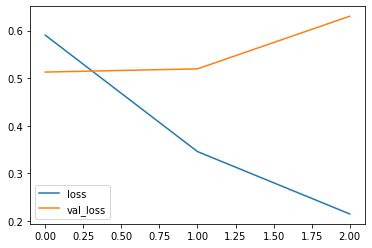

In [30]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
plt.show()

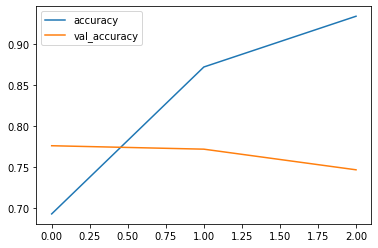

In [31]:
history_df.loc[0:, ['accuracy','val_accuracy']].plot()
plt.show()

## Predictions

In [32]:
corpus_test=test['text'].values
X_test=vectorizer.transform(corpus_test).toarray()
prediction = LogisticRegression_classifier.predict(X_test)
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
#prediction = model.predict(X_test_tok_pad)

prediction

array([1, 1, 1, ..., 1, 1, 1])

In [34]:
y_pred = (prediction > 0.5).astype(int)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [35]:
sub = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
sub['target'] = y_pred
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [37]:
sub.to_csv('submission3.csv', index=False)